In [1]:
import uproot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
def doubleExp(x, A, B, a, b):
    return (1.-A)*(B/a*np.exp(-x/a)+(1-B)/b*np.exp(-x/b))

def singleExp(x, A, a):
    return A*np.exp(-x/a)

def chisq(yReal,yPred,sigma): #assume error of each point accords Poisson distribution
        x = 0.
        #sigma = [np.sqrt(x) for x in yPred]
        for i in range(len(yReal)):
            if(yReal[i]==0 or yPred[i]==0 or sigma[i]==0): continue
            x+=((yReal[i]-yPred[i])/sigma[i])**2.0

        return x/len(yReal)

def polyDeg1(x,a,b):
    return a*x+b

def polyDeg2(x,a,b,c):
    return a*x**2.+b*x+c

def polyDeg3(x,a,b,c,d):
    return a*x**3.+b*x**2.+c*x+d

def polyDeg4(x,a,b,c,d,e):
    return a*x**4.+b*x**3.+c*x**2.+d*x+e

In [3]:
file = uproot.open("photonTimingR9.428cm.root")
print(file.keys())

['photon_timing_0-100;1', 'photon_timing_top_0-100;1', 'photon_timing_bottom_0-100;1', 'photon_timing_100-200;1', 'photon_timing_top_100-200;1', 'photon_timing_bottom_100-200;1', 'photon_timing_200-300;1', 'photon_timing_top_200-300;1', 'photon_timing_bottom_200-300;1', 'photon_timing_300-400;1', 'photon_timing_top_300-400;1', 'photon_timing_bottom_300-400;1', 'photon_timing_400-500;1', 'photon_timing_top_400-500;1', 'photon_timing_bottom_400-500;1', 'photon_timing_500-600;1', 'photon_timing_top_500-600;1', 'photon_timing_bottom_500-600;1', 'photon_timing_600-700;1', 'photon_timing_top_600-700;1', 'photon_timing_bottom_600-700;1', 'photon_timing_700-800;1', 'photon_timing_top_700-800;1', 'photon_timing_bottom_700-800;1', 'photon_timing_800-900;1', 'photon_timing_top_800-900;1', 'photon_timing_bottom_800-900;1', 'photon_timing_900-1000;1', 'photon_timing_top_900-1000;1', 'photon_timing_bottom_900-1000;1', 'photon_timing_1000-1100;1', 'photon_timing_top_1000-1100;1', 'photon_timing_botto

In [4]:
# pmt_pos = pd.read_csv('PMTpositions-LZ-26Feb20.txt',sep='\s+')
# pmt_ch = np.array(pmt_pos['Channel'])
# pmt_x = np.array(pmt_pos['Xpos'])/10.
# pmt_y = np.array(pmt_pos['Ypos'])/10.
# pmt_z = np.array(pmt_pos['Zpos'])/10.

# maskTPC = pmt_ch<550
# pmt_x = pmt_x[maskTPC]
# pmt_y = pmt_y[maskTPC]
# pmt_z = pmt_z[maskTPC]
# pmt_r = np.sqrt(pmt_x**2.+pmt_y**2.)

# print(max(pmt_z),min(pmt_z))
# print(max(pmt_r),min(pmt_r))

# lvalue, hvalue = 600, 700
# Zmax = max([153.9-lvalue/10., 153.9-hvalue/10., 14.8+lvalue/10., 14.8+hvalue/10.])
# print(Zmax)
# path = np.sqrt(82.73**2.0+Zmax**2.0)
# Tdirect = path/17.75  # ns
# print(path,round(Tdirect))

z = 1400-1500, all TPC PMTs
Top: Bottom = 0.62 : 0.38
Ratio for which photons are directly detected A = 0.0459


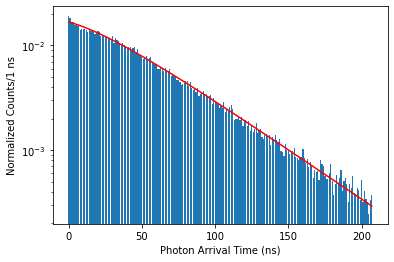

chisq: 1.35
Para: B=1.247+-0.085 ta=45.649+-1.109 tb=23.38+-2.773


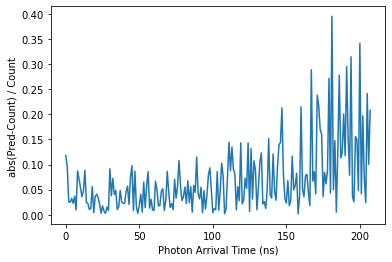

chisq: 133.4
Para: A=0.198+-0.002 ta=5.919+-0.083


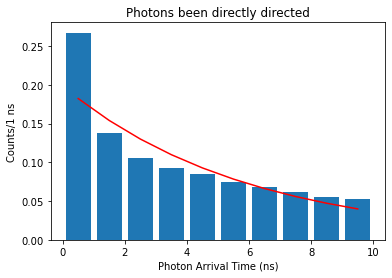

In [5]:
# example
lvalue, hvalue = 1400, 1500

print(f'z = {lvalue}-{hvalue}, all TPC PMTs')
PT = file[f'photon_timing_{lvalue}-{hvalue};1'].to_numpy()

top, _ = file[f'photon_timing_top_{lvalue}-{hvalue};1'].to_numpy()
bot, _ = file[f'photon_timing_bottom_{lvalue}-{hvalue};1'].to_numpy()
assert sum(PT[0])==(sum(top)+sum(bot))
print(f'Top: Bottom = {round(sum(top)/(sum(top)+sum(bot)),2)} : {round(sum(bot)/(sum(top)+sum(bot)),2)}')

# print(f'Depth {lvalue}-{hvalue}, Top TPC PMTs')
# PT = file[f'photon_timing_top_{lvalue}-{hvalue};1'].to_numpy()

# print(f'Depth {lvalue}-{hvalue}, Bottom TPC PMTs')
# PT = file[f'photon_timing_bottom_{lvalue}-{hvalue};1'].to_numpy()

## Calculate the max time when photons are directly detected
Zmax = max([153.9-lvalue/10., 153.9-hvalue/10., 14.8+lvalue/10., 14.8+hvalue/10.])
path = np.sqrt(82.73**2.0+Zmax**2.0)
Tdirect = path/17.75 # ns

counts, bins = PT

## Original Distribution
# plt.stairs(counts, bins)
# plt.xlim(0,250)
# plt.yscale('log')
# plt.xlabel('Photon Arrival Time (ns)')
# plt.ylabel('Counts/1 ns')
# plt.show()

## Calculate and only include times when 99% of area is achieved
times = []
for j in range(len(bins)-1): # select mid point of each bin
    times.append((bins[j]+bins[j+1])/2.)
    
diff = []
Acc = 0.99
for i in range(1,len(counts)):
    summ = sum(counts[:i])/sum(counts)
    diff.append(abs(summ-Acc))
ind = np.argmin(diff)
timeCut = times[ind]
#print(f'time when area fraction is {Acc*100}%: '+str(times[ind]))

times, counts = np.array(times), np.array(counts)
mask = times<timeCut
times = times[mask]
counts = counts[mask]

## Obtain the times & counts for which photon are directly detected
directTimes = times[times<Tdirect]
directCounts = counts[times<Tdirect]

## Exclude times & counts for which photons are directly detected
mask2 = times>Tdirect
times = times[mask2]
A = 1-len(counts[mask2])/len(counts)
print(f'Ratio for which photons are directly detected A = {round(A,4)}')
counts = counts[mask2]
times = [x-min(times) for x in times]

## Calculate sigma and normalization
summ = sum(counts)
sigma = [np.sqrt(x) for x in counts]
sigma = [x/sum(counts) for x in sigma]
counts = [x/summ for x in counts]

## Fit double exponential functions
para = curve_fit(doubleExp, times, counts, maxfev = 3000, sigma=sigma, absolute_sigma=True, bounds=([-0.6,0.8,42,0],[1.2,1.3,50,25]))
Prob_pred = [doubleExp(x,para[0][0],para[0][1],para[0][2],para[0][3]) for x in times]
error = np.array(np.sqrt(np.diag(para[1])))

## Plot fitting results
plt.bar(times, counts)
#plt.stairs(counts, bins)
plt.plot(times,Prob_pred,c='r')
plt.yscale('log')
#plt.xlim(0,100)
#plt.ylim(10**(-4.), 10**(-1.))
plt.xlabel('Photon Arrival Time (ns)')
plt.ylabel('Normalized Counts/1 ns')
plt.show()
print('chisq: '+str(round(chisq(counts,Prob_pred,sigma),2)))
print(f'Para: B={round(para[0][1],3)}+-{round(error[1],3)} ta={round(para[0][2],3)}+-{round(error[2],3)} tb={round(para[0][3],3)}+-{round(error[3],3)}')

# Plot abs(fit-count)/count, relative difference
relDiff = []
for n in range(len(counts)):
    relDiff.append(abs(counts[n]-Prob_pred[n])/counts[n])
plt.plot(times, relDiff)
plt.xlabel('Photon Arrival Time (ns)')
plt.ylabel('abs(Pred-Count) / Count ')
plt.show()

# fit single exponential function to photons been directly directed
sigmaDirect = [np.sqrt(x) for x in directCounts]
summ = np.sum(directCounts)
directCounts = [x/summ for x in directCounts]
sigmaDirect = [x/summ for x in sigmaDirect]
para = curve_fit(singleExp, directTimes, directCounts, maxfev = 3000, sigma=sigmaDirect, absolute_sigma=True)
Prob_pred = [singleExp(x,para[0][0],para[0][1]) for x in directTimes]
error = np.array(np.sqrt(np.diag(para[1])))
print('chisq: '+str(round(chisq(directCounts,Prob_pred,sigmaDirect),2)))
print(f'Para: A={round(para[0][0],3)}+-{round(error[0],3)} ta={round(para[0][1],3)}+-{round(error[1],3)}')

plt.bar(directTimes, directCounts)
plt.plot(directTimes,Prob_pred,c='r')
#plt.yscale('log')
plt.xlabel('Photon Arrival Time (ns)')
plt.ylabel('Counts/1 ns')
plt.title('Photons been directly directed')
plt.show()

In [6]:
DepthL, DepthU = np.arange(0,1500,100), np.arange(100,1600,100)
Depth, A_array, B, a, b, chisq_array, CutTime, RatioTB, Tdirect_array, RatioDirect, MaxRelDiff = [],[],[],[],[],[],[],[],[],[],[]
A_array_err, B_err, a_err, b_err = [],[],[],[]

direct_A, direct_Aerr, direct_a, direct_aerr, direct_chisq = [],[],[],[],[]

sim_all=[]

for i in range(len(DepthL)):
    name = str(DepthL[i])+'-'+str(DepthU[i])
    Depth.append(f'{DepthL[i]}-{DepthU[i]}')
    
    lvalue, hvalue = DepthL[i], DepthU[i]

    #print(f'z = {lvalue}-{hvalue}, all TPC PMTs')
    PT = file[f'photon_timing_{lvalue}-{hvalue};1'].to_numpy()

    top, _ = file[f'photon_timing_top_{lvalue}-{hvalue};1'].to_numpy()
    bot, _ = file[f'photon_timing_bottom_{lvalue}-{hvalue};1'].to_numpy()
    assert sum(PT[0])==(sum(top)+sum(bot))
    RatioTB.append(str(round(sum(top)/(sum(top)+sum(bot)),2))+':'+str(round(sum(bot)/(sum(top)+sum(bot)),2)))
    #print(f'Top: Bottom = {round(sum(top)/(sum(top)+sum(bot)),2)} : {round(sum(bot)/(sum(top)+sum(bot)),2)}')

    ## Calculate the max time when photons are directly detected
    Zmax = max([153.9-lvalue/10., 153.9-hvalue/10., 14.8+lvalue/10., 14.8+hvalue/10.])
    path = np.sqrt(82.73**2.0+Zmax**2.0)
    Tdirect = path/17.75 # ns
    Tdirect_array.append(Tdirect)

    counts, bins = PT

    ## Original Distribution
    # plt.stairs(counts, bins)
    # plt.xlim(0,250)
    # plt.yscale('log')
    # plt.xlabel('Photon Arrival Time (ns)')
    # plt.ylabel('Counts/1 ns')
    # plt.show()

    ## Calculate and only include times when 99% of area is achieved
    times = []
    for j in range(len(bins)-1): # select mid point of each bin
        times.append((bins[j]+bins[j+1])/2.)

    diff = []
    Acc = 0.99
    for k in range(1,len(counts)):
        summ = sum(counts[:k])/sum(counts)
        diff.append(abs(summ-Acc))
    ind = np.argmin(diff)
    timeCut = times[ind]
    #print(f'time when area fraction is {Acc*100}%: '+str(times[ind]))
    CutTime.append(timeCut)

    times, counts = np.array(times), np.array(counts)
    mask = times<timeCut
    times = times[mask]
    counts = counts[mask]

    ## Obtain the times & counts for which photon are directly detected
    directTimes = times[times<Tdirect]
    directCounts = counts[times<Tdirect]

    ## Exclude times & counts for which photons are directly detected
    mask2 = times>Tdirect
    times = times[mask2]
    A = 1-len(counts[mask2])/len(counts)
    RatioDirect.append(round(A,5))
    #print(f'Ratio for which photons are directly detected A = {round(A,2)}')
    counts = counts[mask2]
    times = [x-min(times) for x in times]

    ## Calculate sigma and normalization
    summ = sum(counts)
    sigma = [np.sqrt(x) for x in counts]
    sigma = [x/sum(counts) for x in sigma]
    counts = [x/summ for x in counts]

    ## Fit double exponential functions
    para = curve_fit(doubleExp, times, counts, maxfev = 3000, sigma=sigma, absolute_sigma=True, bounds=([-0.6,0.8,42,0],[1.2,1.3,50,25]))
    Prob_pred = [doubleExp(x,para[0][0],para[0][1],para[0][2],para[0][3]) for x in times]
    error = np.array(np.sqrt(np.diag(para[1])))
    
    sim_all.append(counts)

    ## Plot fitting results
#     plt.bar(times, counts)
#     #plt.stairs(counts, bins)
#     plt.plot(times,Prob_pred,c='r')
#     plt.yscale('log')
#     #plt.xlim(0,100)
#     #plt.ylim(10**(-4.), 10**(-1.))
#     plt.xlabel('Photon Arrival Time (ns)')
#     plt.ylabel('Normalized Counts/1 ns')
#     plt.show()
    #print('chisq: '+str(round(chisq(counts,Prob_pred,sigma),2)))
    #print(f'Para: B={round(para[0][1],3)}+-{round(error[1],3)} ta={round(para[0][2],3)}+-{round(error[2],3)} tb={round(para[0][3],3)}+-{round(error[3],3)}')
    A_array.append(round(para[0][0],3))
    B.append(round(para[0][1],3))
    a.append(round(para[0][2],3))
    b.append(round(para[0][3],3))
    chisq_array.append(round(chisq(counts,Prob_pred,sigma),2))
    A_array_err.append(round(error[0],3))
    B_err.append(round(error[1],3))
    a_err.append(round(error[2],3))
    b_err.append(round(error[3],3))
    
    # Plot abs(fit-count)/count, relative difference
    relDiff = []
    for n in range(len(counts)):
        relDiff.append(abs(counts[n]-Prob_pred[n])/counts[n])
#     plt.plot(times, relDiff)
#     plt.xlabel('Photon Arrival Time (ns)')
#     plt.ylabel('abs(Pred-Count) / Count ')
#     plt.show()
    
    MaxRelDiff.append(round(max(relDiff),2))
    
    
    # fit to photons been directly detected
    sigmaDirect = [np.sqrt(x) for x in directCounts]
    summ = np.sum(directCounts)
    directCounts = [x/summ for x in directCounts]
    sigmaDirect = [x/summ for x in sigmaDirect]
    para = curve_fit(singleExp, directTimes, directCounts, maxfev = 3000, sigma=sigmaDirect, absolute_sigma=True)
    Prob_pred = [singleExp(x,para[0][0],para[0][1]) for x in directTimes]
    error = np.array(np.sqrt(np.diag(para[1])))
    #print('chisq: '+str(round(chisq(directCounts,Prob_pred,sigmaDirect),2)))
    #print(f'Para: A={round(para[0][0],3)}+-{round(error[0],3)} ta={round(para[0][1],3)}+-{round(error[1],3)}')
    
    ## plotting fitting results of photons been direclty detected
    #plt.bar(directTimes, directCounts)
    #plt.plot(directTimes,Prob_pred,c='r')
    #plt.yscale('log')
    #plt.xlabel('Photon Arrival Time (ns)')
    #plt.ylabel('Counts/1 ns')
    #plt.title('Photons been directly directed')
    #plt.show()
    
    direct_A.append(round(para[0][0],3))
    direct_Aerr.append(round(error[0],3)) 
    direct_a.append(round(para[0][1],3)) 
    direct_aerr.append(round(error[1],3)) 
    direct_chisq.append(round(chisq(directCounts,Prob_pred,sigmaDirect),2))
    
    #if(DepthL[i]==1100 or DepthL[i]==1200 or DepthL[i]==1300 or DepthL[i]==1400):
        #plt.step(times, counts,label=name,alpha=0.5)
        #print(sum(counts[:120])/sum(counts))
        #plt.bar(times, counts,label=name,alpha=0.5)

# plt.xlabel('Photon Arrival Time (ns)')
# plt.ylabel('Counts/1 ns')
# plt.title('Photons Transit Times')
# #plt.yscale('log')
# plt.legend()
# plt.show()

In [7]:
# df_direct=pd.DataFrame(zip(Depth, direct_A, direct_Aerr, direct_a, direct_aerr, direct_chisq)
#                 ,columns=['z (mm)','A','A_err','a','a_err','chisq'])
# print(df_direct)

In [12]:
df=pd.DataFrame(zip(Depth, A_array, A_array_err, B, B_err, a, a_err, b, b_err, chisq_array, CutTime, RatioTB, Tdirect_array, RatioDirect, MaxRelDiff)
                ,columns=['z (mm)','A','A_err','B','B_err','a','a_err','b','b_err','chisq','CutTime','Top:Bottom','MaxT_direct','Ratio_direct','Max Relative Diff'])
print(df)
#df.to_pickle(f'/global/cfs/cdirs/lz/users/yqie/PhotonTimingAlgo/SR1Events/{name}run{runID[i]}_event_{eventID[i]}_Info.pkl')  

       z (mm)      A  A_err      B  B_err       a  a_err       b  b_err  \
0       0-100 -0.002  0.001  0.997  0.001  47.662  0.044   4.551  0.870   
1     100-200 -0.002  0.001  1.006  0.002  47.734  0.067  10.839  2.262   
2     200-300 -0.002  0.001  1.018  0.001  47.784  0.062   9.378  0.579   
3     300-400 -0.002  0.001  1.034  0.001  47.831  0.062   9.201  0.306   
4     400-500 -0.003  0.001  1.049  0.002  47.865  0.067   9.721  0.245   
5     500-600 -0.003  0.001  1.070  0.002  47.807  0.072  10.448  0.206   
6     600-700 -0.003  0.001  1.087  0.002  47.754  0.082  11.511  0.217   
7     700-800 -0.003  0.001  1.106  0.003  47.551  0.098  13.114  0.256   
8     800-900 -0.003  0.001  1.120  0.004  47.304  0.121  14.687  0.326   
9    900-1000 -0.003  0.001  1.142  0.006  47.087  0.155  16.531  0.418   
10  1000-1100 -0.003  0.001  1.172  0.011  46.705  0.217  18.968  0.581   
11  1100-1200 -0.003  0.001  1.181  0.015  46.618  0.276  19.808  0.744   
12  1200-1300 -0.003  0.0

Polynomial fit of degree 1


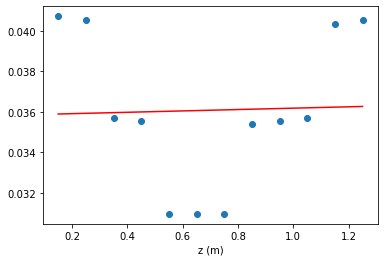

chisq: 13.26
Para: a=0.0003388104871146748+-0.003335337828515866 b=0.03584699932568682+-0.002603202612405601
Polynomial fit of degree 2


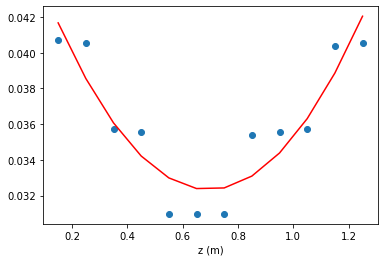

chisq: 2.22
Para: a=0.03150724264719133+-0.00470464053521772 b=-0.04377132851860628+-0.0067414943398974156 c=0.04753093464873876+-0.002074169865165398
Polynomial fit of degree 3


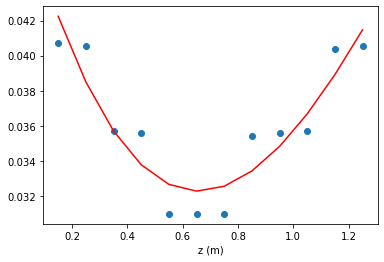

chisq: 2.09
Para: a=-0.011599317410246767+-0.016434706179807225 b=0.05586580902875414+-0.03485082330092248 c=-0.05835746991444132+-0.021800042778882065 d=0.049784101994537935+-0.0038403040999846474
Polynomial fit of degree 4


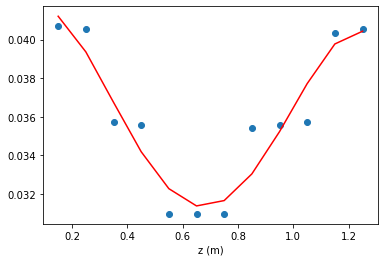

chisq: 1.42
Para: a=-0.09228578486090455+-0.050809479076838915 b=0.2468008727129738+-0.1430020273333335 c=-0.1878345656482583+-0.1376442610129219 d=0.029590873594444914+-0.05209407800487135 e=0.04020558056499018+-0.006266329197051337


In [13]:
Ratio_err = [0.001]*len(RatioDirect)
tryy, err = RatioDirect[1:13], Ratio_err[1:13]
#z_array = np.arange(50,1550,100)
z_array = np.arange(0.15,1.26,0.1)

    
print('Polynomial fit of degree 1')
#para = curve_fit(polyDeg1, z_array, tryy, maxfev = 3000, sigma=err, absolute_sigma=True)
para = curve_fit(polyDeg1, z_array, tryy, maxfev = 3000)
Prob_pred = [polyDeg1(x,para[0][0],para[0][1]) for x in z_array]
error = np.array(np.sqrt(np.diag(para[1])))
plt.scatter(z_array, tryy)
plt.plot(z_array,Prob_pred,c='r')
plt.xlabel('z (m)')
plt.show()
    
print('chisq: '+str(round(chisq(tryy,Prob_pred,err),2)))
print(f'Para: a={para[0][0]}+-{error[0]} b={para[0][1]}+-{error[1]}')
    


print('Polynomial fit of degree 2')
#para = curve_fit(polyDeg2, z_array, tryy, maxfev = 3000, sigma=err, absolute_sigma=True)
para = curve_fit(polyDeg2, z_array, tryy, maxfev = 3000)
Prob_pred = [polyDeg2(x,para[0][0],para[0][1],para[0][2]) for x in z_array]
error = np.array(np.sqrt(np.diag(para[1])))
plt.scatter(z_array, tryy)
plt.plot(z_array,Prob_pred,c='r')
plt.xlabel('z (m)')
plt.show()
                  
print('chisq: '+str(round(chisq(tryy,Prob_pred,err),2)))
print(f'Para: a={para[0][0]}+-{error[0]} b={para[0][1]}+-{error[1]} c={para[0][2]}+-{error[2]}')
    


print('Polynomial fit of degree 3')
#para = curve_fit(polyDeg3, z_array, tryy, maxfev = 3000, sigma=err, absolute_sigma=True)
para = curve_fit(polyDeg3, z_array, tryy, maxfev = 3000)
Prob_pred = [polyDeg3(x,para[0][0],para[0][1],para[0][2],para[0][3]) for x in z_array]
error = np.array(np.sqrt(np.diag(para[1])))
plt.scatter(z_array, tryy)
plt.plot(z_array,Prob_pred,c='r')
plt.xlabel('z (m)')
plt.show()
    
print('chisq: '+str(round(chisq(tryy,Prob_pred,err),2)))
print(f'Para: a={para[0][0]}+-{error[0]} b={para[0][1]}+-{error[1]} c={para[0][2]}+-{error[2]} d={para[0][3]}+-{error[3]}')
    


print('Polynomial fit of degree 4')
#para = curve_fit(polyDeg4, z_array, tryy, maxfev = 3000, sigma=err, absolute_sigma=True)
para = curve_fit(polyDeg4, z_array, tryy, maxfev = 3000)
Prob_pred = [polyDeg4(x,para[0][0],para[0][1],para[0][2],para[0][3],para[0][4]) for x in z_array]
error = np.array(np.sqrt(np.diag(para[1])))
plt.scatter(z_array, tryy)
plt.plot(z_array,Prob_pred,c='r')
plt.xlabel('z (m)')
plt.show()
    
print('chisq: '+str(round(chisq(tryy,Prob_pred,err),2)))
print(f'Para: a={para[0][0]}+-{error[0]} b={para[0][1]}+-{error[1]} c={para[0][2]}+-{error[2]} d={para[0][3]}+-{error[3]} e={para[0][4]}+-{error[4]}')

In [22]:
# B_coeff = [0.084, -0.264, 0.301, 0.035, 0.995]
# B_coeff_err = [0.069, 0.154, 0.109, 0.027, 0.002]
# a_coeff = [-2.06, 1.51, 47.58]
# a_coeff_err = [0.24, 0.23, 0.04]
# b_coeff = [-1.75, 10.28, 1.35, 7.09]
# b_coeff_err = [3.11, 6.59, 4.31, 0.90]
# r_coeff = [-0.092, 0.247, -0.188, 0.030, 0.040]
# r_coeff_err = [0.051, 0.143, 0.138, 0.052, 0.006]
# # 4-2-3-4

B_coeff = [0.033, 0.137, 0.983]
B_coeff_err = [0.009, 0.014, 0.004]
a_coeff = [1.468, -5.077, 3.260, 47.304]
a_coeff_err = [0.589, 1.250, 0.782, 0.138]
b_coeff = [-19.330, 52.954, -30.180, 14.138]
b_coeff_err = [2.341, 4.964, 3.105, 0.547]

In [23]:
# pdf -> random sampling
z_range = np.arange(0,1500,100)
Dist_all = []
for i in tqdm(range(len(z_range))):
    photons = np.random.uniform(0,1,10000)
    photons_z = [(int(x*100)+z_range[i])/1000. for x in photons]
    #print(sorted(photons_z))
    dist = []
    for h in photons_z:
        
#         B = B_coeff[0]*h**4.+B_coeff[1]*h**3.+B_coeff[2]*h**2.+B_coeff[3]*h+B_coeff[4]
#         a = a_coeff[0]*h**2.+a_coeff[1]*h+a_coeff[2]
#         b = b_coeff[0]*h**3.+b_coeff[1]*h**2.+b_coeff[2]*h+b_coeff[3]

        B = B_coeff[0]*h**2.+B_coeff[1]*h+B_coeff[2]
        a = a_coeff[0]*h**3.+a_coeff[1]*h**2.+a_coeff[2]*h+a_coeff[3]
        b = b_coeff[0]*h**3.+b_coeff[1]*h**2.+b_coeff[2]*h+b_coeff[3]
    
        t = np.arange(0,250,1)
        pdf = B/a*np.e**(-t/a)+(1.-B)/b*np.e**(-t/b)
        pdf = [x/sum(pdf) for x in pdf]
        cdf = [0]
        for j in range(1,len(pdf)):
            cdf.append(sum(pdf[:j]))
        generator = interp1d(cdf,t)
        y = np.random.uniform(0,0.99,1)
        TransitTime = generator(y[0])
        dist.append(TransitTime)
    Dist_all.append(dist)

100%|███████████████████████████████████████████| 15/15 [08:37<00:00, 34.51s/it]


In [24]:
print(len(Dist_all))

15


In [25]:
df=pd.DataFrame(zip(Dist_all[0], Dist_all[1], Dist_all[2], Dist_all[3], Dist_all[4], Dist_all[5], 
                    Dist_all[6], Dist_all[7], Dist_all[8], Dist_all[9], Dist_all[10], Dist_all[11], 
                   Dist_all[12], Dist_all[13], Dist_all[14])
                ,columns=['0-100','100-200','200-300','300-400','400-500','500-600','600-700',
                          '700-800','800-900','900-1000','1000-1100','1100-1200','1200-1300','1300-1400','1400-1500'])
#print(df)
#df.to_pickle('PhotonTransitCheck.pkl')  

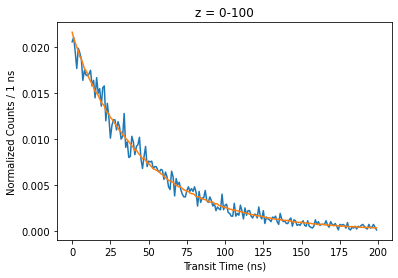

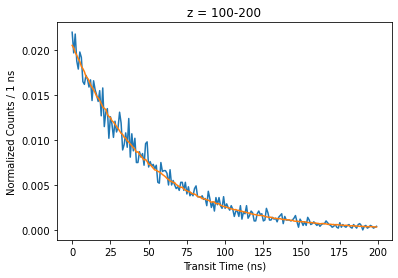

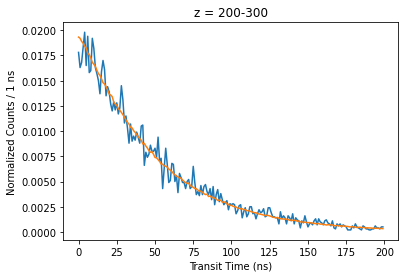

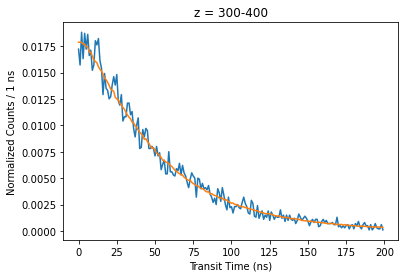

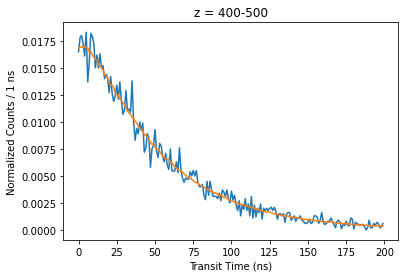

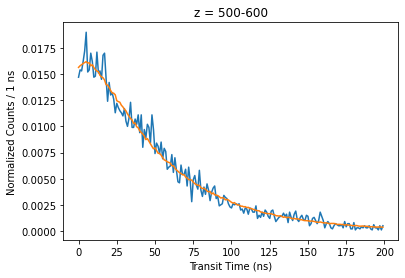

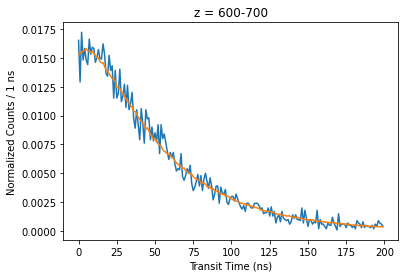

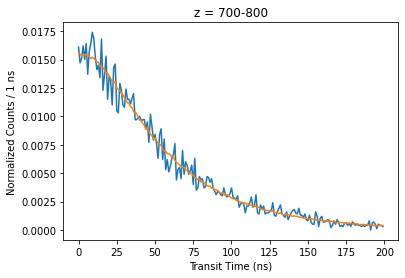

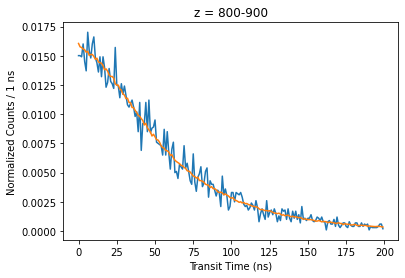

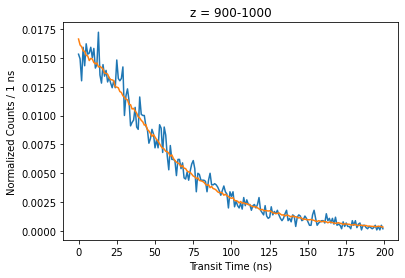

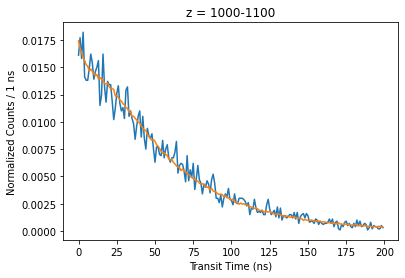

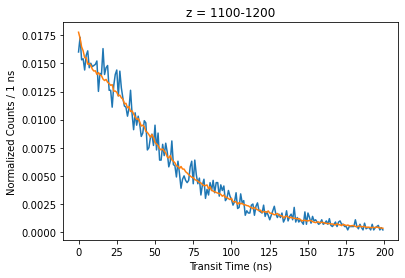

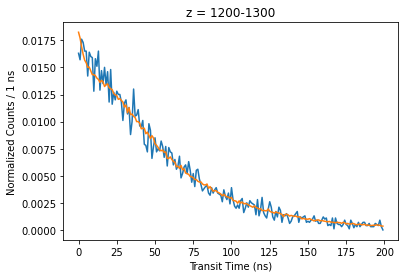

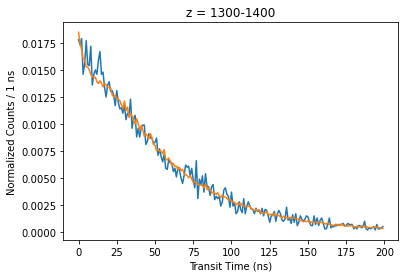

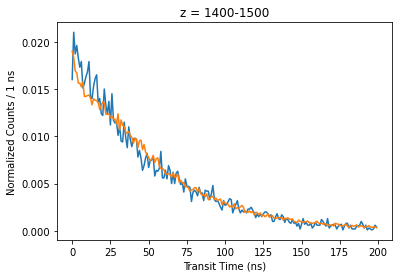

In [26]:
df = pd.read_pickle('PhotonTransitCheck.pkl')
depthL = np.arange(0,1500,100)
t = np.arange(0,200,1)
for i in range(len(depthL)):
    generator = np.array(df[f'{int(depthL[i])}-{int(depthL[i]+100)}'])
    sim_dist = sim_all[i][:200]
    t2 = np.arange(0,201,1)
    values = np.histogram(generator, bins=t2)
    sampling = [x/sum(values[0]) for x in values[0]]
    plt.plot(t,sampling,label='Generator')
    plt.plot(t,sim_dist,label='Simulation')
    plt.title(f'z = {int(depthL[i])}-{int(depthL[i]+100)}')
    plt.xlabel('Transit Time (ns)')
    plt.ylabel('Normalized Counts / 1 ns')
    plt.show()